# making an aggregate master dataframe for baseline model  10/22/18 -11/6/18
this notebook is going to make standardized longformat dataframes for each dataframe that i will adjust for each model to. 

for my first pass, i will work to establish a baseline model by using:
the single "worst", or value that most indicates poor clinical outcomes, for each variable so each variable only has one row per patient. 


- make a long format table(ie variable, patient, time, value)
 - step1:Standardize all columns, format, etc. 
 - step2: Maybe make a long format table for each dataframe
 - step3: Impute
 
- combine features from each long table for 1 wide table (ie each patient has a row, each parameter has a column). 
 - feature select for "Clinical worst case" 



- Establish a baseline (ie train model initially), using an obvious baseline: last valid mesurement of a particular variable.   Will hope that it doesn’t perform too good or too bad. Second would be to pick an aggregate within a time window (over 3 days, or of each day, ie can change graunlarity).

- Next try temporal trend, maybe vector autoregression. 

So my first step would be to pick either the last recorded value for each variable or the ‘worst’ value, or ones that we might expect to indicate poor outcome (NEED TO CHOOSE)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

In [2]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 91.2 ms


In [3]:
# #adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
# import psycopg2
# import getpass
# conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
#                         password=getpass.getpass(prompt='Password:'.format()))
# cur=conn.cursor()

# query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 1.57 ms


In [4]:
#import all clinical variables
##ensure they are the versions with UOM

time: 749 µs


In [5]:
#importing in all clinical_variable files
date= '14112018'
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/')
allFiles = glob.glob(os.getcwd() + "/{}_*.csv".format(date))

time: 2.82 ms


In [6]:
os.getcwd()

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed'

time: 3.05 ms


In [7]:
allFiles  #need to rerun 03.1-clinical_variables and have a new date to make it easier. 

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_rrt_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_pafaRatio_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_vitals_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_ventcategory_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_sofa_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_bg_all_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_gcs_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_phenylephrine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_epinephrine_pr

time: 2.03 ms


In [8]:
#making a dictionary of all my dataframes for easier cycling through

df_list=[]
for element in allFiles:
    df_list.append(element.split('{}_'.format(date))[1].split('_prepped.csv')[0]) #making an list of all my dataframes in order they appear in file

dfs = {}
i=0
for name in df_list:
    dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 13.4 s


In [9]:
#all of the column names 
for element in df_list:
    print(element,':',list(dfs[element]))

rrt : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
pafaRatio : ['icustay_id', 'hadm_id', 't_0', 'value', 'delta', 'uom', 'label']
vitals : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'uom', 'label', 'value', 't_0', 'delta']
ventcategory : ['icustay_id', 'uom', 't_0', 'label', 'value', 'delta']
sofa : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
bg_all : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'delta', 't_0', 'label', 'valuenum', 'uom']
gcs : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
phenylephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
epinephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
bg_ART : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'delta', 't_0', 'label', 'valuenum', 'uom']
nit : ['subject_id', 'hadm_id', 't_0', 'label', 'value', 'delta', 'icustay_id', 'uom']
norepinephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delt

## standardizing columns

#### adding icustay_id, dropping hadm_id

In [10]:
##dropping hadm_id from all:
list1=[]
for element in df_list:
    if 'hadm_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('hadm_id', axis=1)

time: 626 ms


In [11]:
##dropping subject_id from all:
list1=[]
for element in df_list:
    if 'subject_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('subject_id', axis=1)

time: 505 ms


In [12]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

rrt : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
pafaRatio : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
vitals : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
bg_all : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'valuenum']
gcs : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
phenylephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
epinephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
bg_ART : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'valuenum']
nit : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
norepinephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
o2_flow : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
labs : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
vasopressin : [

In [13]:
#dropping charttime, endtime and first_charttime

list1=[]
list2=[]
for element in df_list:
    if 'charttime' in (list(dfs[element])):
        list1.append(element)
    if 'endtime' in (list(dfs[element])):
        list2.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('charttime', axis=1)

for element in list2:
    dfs[element]= dfs[element].drop('endtime', axis=1)
    
#dfs['rrt']= dfs['rrt'].drop('first_charttime', axis=1)

time: 498 ms


In [14]:
#converting valuenum and value to same label
list1=[]

for element in df_list:
    if 'valuenum' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].rename(index=str, columns={'valuenum':'value'})


time: 152 ms


In [15]:
def label_lower(df_name):
    dfs[df_name]['label']= dfs[df_name]['label'].apply(lambda x: x.lower())

time: 1.1 ms


In [16]:
#turning all labels to lowercase
for element in df_list:
    label_lower(element)


time: 2.63 s


In [17]:
#adding a df source table label to each df. 
for element in df_list:
    dfs[element]['source']=element

#adding a patient id to each

for element in df_list:
    dfs[element]= pd.merge(dfs[element], final_pt_df2[['icustay_id','subject_id']], how='left')
    

time: 3.12 s


In [18]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

rrt : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
pafaRatio : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
vitals : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
bg_all : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
gcs : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
phenylephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
epinephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
bg_ART : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
nit : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
norepinephr

# converting data formats

In [19]:
#na

time: 662 µs


# looking at measured values

In [20]:
df_list

['rrt',
 'pafaRatio',
 'vitals',
 'ventcategory',
 'sofa',
 'bg_all',
 'gcs',
 'phenylephrine',
 'epinephrine',
 'bg_ART',
 'nit',
 'norepinephrine',
 'o2_flow',
 'labs',
 'vasopressin',
 'leuk',
 'dopamine',
 'dobutamine',
 'weight']

time: 2.25 ms


In [21]:
def value_viewer(df_name):
    return(dfs[df_name]['label'].unique())

time: 1.38 ms


In [22]:
value_viewer('bg_ART')

array(['pco2'], dtype=object)

time: 4.74 ms


In [23]:
value_viewer('bg_all')

array(['calcium', 'lactate', 'ph', 'temperature', 'hemoglobin',
       'potassium', 'glucose', 'chloride', 'sodium', 'bicarbonate'],
      dtype=object)

time: 14 ms


In [24]:
#value_viewer('uti')

time: 596 µs


In [25]:
value_viewer('labs')


array(['sodium', 'bicarbonate', 'chloride', 'creatinine', 'glucose',
       'potassium', 'bun', 'hemoglobin', 'platelet', 'wbc', 'lactate',
       'inr', 'ptt', 'bilirubin', 'bands'], dtype=object)

time: 49.8 ms


In [26]:
value_viewer('vitals')

array(['meanartpress', 'sysbp', 'heartrate', 'resprate', 'spo2',
       'temperature', 'glucose', 'diasbp'], dtype=object)

time: 288 ms


In [27]:
list(dfs)

['rrt',
 'pafaRatio',
 'vitals',
 'ventcategory',
 'sofa',
 'bg_all',
 'gcs',
 'phenylephrine',
 'epinephrine',
 'bg_ART',
 'nit',
 'norepinephrine',
 'o2_flow',
 'labs',
 'vasopressin',
 'leuk',
 'dopamine',
 'dobutamine',
 'weight']

time: 1.81 ms


# combining data

In [28]:
set(value_viewer('labs')) & set(value_viewer('bg_all'))

{'bicarbonate',
 'chloride',
 'glucose',
 'hemoglobin',
 'lactate',
 'potassium',
 'sodium'}

time: 47.3 ms


In [29]:
set(value_viewer('labs')) & set(value_viewer('vitals'))

{'glucose'}

time: 338 ms


In [30]:
set(value_viewer('bg_all')) & set(value_viewer('vitals'))

{'glucose', 'temperature'}

time: 290 ms


In [31]:
# (dfs['labs'].loc[
#     dfs['labs'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 914 µs


In [32]:
# (dfs['vitals'].loc[
#     dfs['vitals'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 1.54 ms


In [33]:
# (dfs['bg_all'].loc[
#     dfs['bg_all'].loc[:,'label']=='glucose', ['label','valuenum']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 1 ms


### merging labs together

In [34]:
# lab_bg_vital= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 494 µs


In [35]:
# lab_bg_vital.head()

time: 487 µs


In [36]:
# #rounding timedeltas to the 2 minute mark. 
# #pd.to_datetime(lab_bg_vital['delta'])#.dt.round('m')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])
# lab_bg_vital['delta']= pd.to_datetime(lab_bg_vital['delta']).dt.round('2min')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])


# #note this is more efficient than rounding timedeltas for some reason. 

time: 1.02 ms


In [37]:
# lab_bg_vital.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #n=7001349 at 1 min, 6913527 at 2min rounding,  vs 7222647 without. 

time: 424 µs


In [38]:
# list(lab_bg_vital['label'].unique())

time: 386 µs


# combining all df

In [39]:
#testing combining all df's
##this may not be a useful exercise, but experimenting. 

time: 517 µs


In [40]:
#big_df= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 469 µs


In [41]:
# making one big dataframe via pd. concat
big_df= pd.concat(dfs.values(), sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)
#converting delta to time delta, to datetime rounded to 2 minutes, and back to time delta (more efficient than rounding timedeltas)
big_df['delta']= pd.to_timedelta(big_df['delta'])
big_df['delta']= pd.to_datetime(big_df['delta']).dt.round('2min')
big_df['delta']= pd.to_timedelta(big_df['delta'])

time: 58.9 s


In [42]:
len(big_df)

7541351

time: 2.58 ms


In [43]:
big_df= big_df.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #7638425  -> 7315304 at 2 min. 

time: 4.24 s


In [44]:
len(big_df)

7217534

time: 2.47 ms


In [45]:
big_df.head()

,icustay_id,t_0,value,label,uom,delta,source,subject_id
0,200012.0,2153-12-23,Neg/Not_tested,leukocyte,pos/neg category,0 days,leuk,28448
0,200012.0,2153-12-23,Neg/Not_tested,nitrite,pos/neg category,0 days,nit,28448
0,200012.0,2153-12-23,None,vent_recieved,mech/O2/none category,0 days,ventcategory,28448
24406,200012.0,2153-12-23,1,daily_sofa,daily_sofa_score,0 days,sofa,28448
1646,200012.0,2153-12-23,0,dobutamine,y/n,0 days,dobutamine,28448


time: 17 ms


In [46]:
big_df.groupby('label')['value'].describe()

,count,unique,top,freq
label,,,,
bands,3516,96,1,472
bicarbonate,63305,56,24,5233
bilirubin,17814,407,0.4,1477
bun,63048,195,14,1909
calcium,29926,170,1.13,1560
chloride,68805,84,106,4442
creatinine,63315,185,0.7,5450
daily_sofa,31545,24,1,5934
diasbp,910423,203,56,28790


time: 2.72 s


In [47]:
big_df[big_df['label']=='leukocyte'].head() #odd, lots of source=nit

,icustay_id,t_0,value,label,uom,delta,source,subject_id
0,200012.0,2153-12-23,Neg/Not_tested,leukocyte,pos/neg category,0 days,leuk,28448
1,200014.0,2105-02-17,Neg/Not_tested,leukocyte,pos/neg category,0 days,leuk,9514
2,200019.0,2178-07-09,Neg/Not_tested,leukocyte,pos/neg category,0 days,leuk,21789
3,200030.0,2150-11-14,Neg/Not_tested,leukocyte,pos/neg category,0 days,leuk,14987
4,200033.0,2198-08-11,Neg/Not_tested,leukocyte,pos/neg category,0 days,leuk,56369


time: 720 ms


In [48]:
big_df['icustay_id'].nunique() #also odd this is not 14668

14668

time: 51 ms


In [49]:
wd

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

time: 1.95 ms


In [50]:
date= '22112018'
pd.DataFrame(big_df).to_csv(Path(
    wd+'/data/processed/%s_longdf_preImp.csv' %(date)))

time: 2min 13s


In [51]:
final_pt_df2.head()

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
0,24915,267059.0,194424,2182-11-12 01:50:00,2182-11-14 00:00:00,full,2182-11-12,2183-01-15,2182-11-11 20:02:17,2183-01-15 00:00:00,2183-01-15 00:00:00,0 days 00:00:00.000000000,NaN,NaN,negative,C_neg/A_full
1,24942,278729.0,178112,2159-11-07 16:57:00,2159-11-10 00:00:00,partial,2159-11-08,2159-11-10,2159-11-06 11:15:58,NaN,NaN,NaN,NaN,NaN,negative,C_neg/A_partial
2,24968,219670.0,120350,2190-07-31 21:40:00,2190-08-03 00:00:00,partial,2190-08-01,2190-08-02,2190-07-31 20:49:51,2190-08-05 00:00:00,2190-08-05 00:00:00,0 days 00:00:00.000000000,NaN,NaN,negative,C_neg/A_partial
3,24776,295185.0,139951,2154-11-10 23:04:00,2154-11-13 00:00:00,full,2154-11-11,2154-11-19,2154-11-07 20:16:08,2154-11-23 00:00:00,2154-11-23 00:00:00,0 days 00:00:00.000000000,ESCHERICHIA COLI,URINE,positive,C_pos/A_full
4,24714,211472.0,163632,2193-12-11 04:00:00,2193-12-13 00:00:00,full,2193-12-11,2193-12-26,2193-12-11 00:20:56,NaN,NaN,NaN,NaN,NaN,negative,C_neg/A_full


time: 20.9 ms


#### making a patient missingness visualization

In [52]:
#big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].agg(['min'])
big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].size()
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 1.37 s


In [53]:
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 165 ms


In [54]:
big_agg_count

label,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,diasbp,dobutamine,...,resprate,rrt,sodium,spo2,sysbp,temperature,vasopressin,vent_recieved,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,...,11.0,1.0,NaN,11.0,10.0,3.0,1.0,1.0,1.0,1.0
200014.0,NaN,3.0,NaN,3.0,3.0,3.0,3.0,1.0,48.0,1.0,...,50.0,1.0,3.0,46.0,49.0,30.0,1.0,1.0,3.0,1.0
200019.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,2.0,47.0,1.0,...,52.0,1.0,2.0,51.0,45.0,9.0,1.0,1.0,2.0,1.0
200030.0,NaN,4.0,1.0,4.0,2.0,4.0,4.0,3.0,82.0,9.0,...,78.0,1.0,4.0,78.0,82.0,27.0,1.0,1.0,3.0,1.0
200033.0,NaN,7.0,NaN,7.0,2.0,11.0,7.0,3.0,82.0,1.0,...,84.0,1.0,12.0,76.0,82.0,23.0,1.0,1.0,3.0,1.0
200036.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,2.0,49.0,1.0,...,62.0,1.0,2.0,58.0,49.0,13.0,1.0,1.0,2.0,1.0
200055.0,NaN,2.0,1.0,2.0,1.0,3.0,2.0,2.0,27.0,1.0,...,30.0,1.0,3.0,30.0,28.0,6.0,1.0,1.0,2.0,1.0
200059.0,NaN,9.0,1.0,8.0,10.0,11.0,8.0,3.0,163.0,1.0,...,135.0,1.0,11.0,98.0,169.0,67.0,1.0,1.0,9.0,1.0
200061.0,NaN,3.0,3.0,3.0,NaN,3.0,3.0,2.0,38.0,1.0,...,38.0,1.0,3.0,38.0,38.0,11.0,1.0,1.0,3.0,1.0


time: 92.9 ms


In [55]:
sns.set(rc={'figure.figsize':(25,15)})

time: 2.44 ms


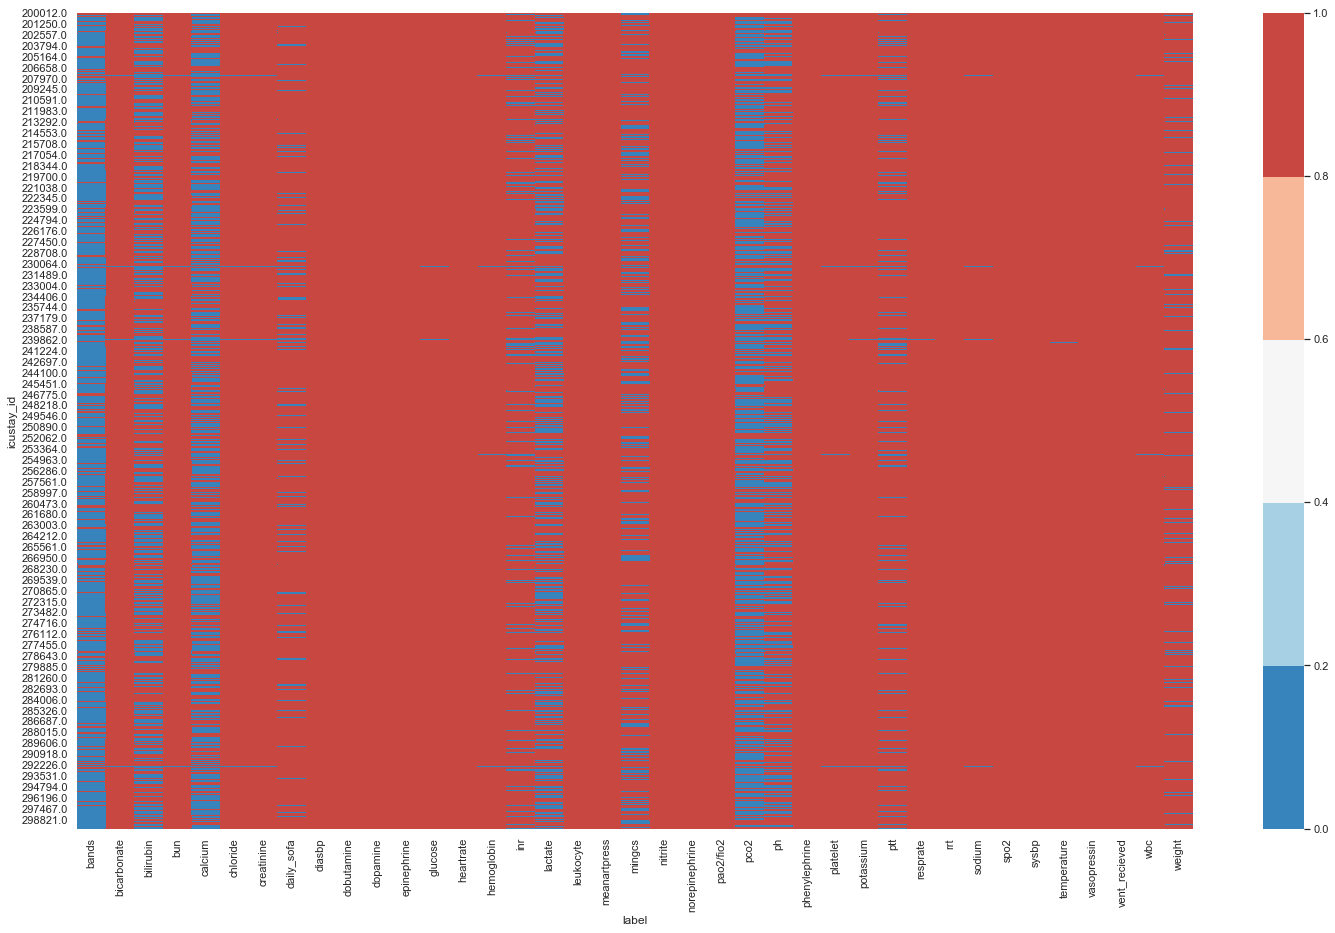

time: 2.44 s


In [56]:
#big_agg_min

#%matplotlib inline

# Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
# Cols = ['A', 'B', 'C', 'D']
# df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

sns.set(rc={'figure.figsize':(25,15)})
big_agg_count= big_agg_count.fillna(0)
big_agg_count = big_agg_count[big_agg_count.columns].astype(float) 


sns.heatmap(big_agg_count,vmin=0, vmax=1, cmap=sns.color_palette("RdBu_r", 5))

In [57]:
len(list(big_agg_count)) #38 columns. 

39

time: 1.91 ms


In [58]:
big_agg_count

label,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,diasbp,dobutamine,...,resprate,rrt,sodium,spo2,sysbp,temperature,vasopressin,vent_recieved,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,...,11.0,1.0,0.0,11.0,10.0,3.0,1.0,1.0,1.0,1.0
200014.0,0.0,3.0,0.0,3.0,3.0,3.0,3.0,1.0,48.0,1.0,...,50.0,1.0,3.0,46.0,49.0,30.0,1.0,1.0,3.0,1.0
200019.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,47.0,1.0,...,52.0,1.0,2.0,51.0,45.0,9.0,1.0,1.0,2.0,1.0
200030.0,0.0,4.0,1.0,4.0,2.0,4.0,4.0,3.0,82.0,9.0,...,78.0,1.0,4.0,78.0,82.0,27.0,1.0,1.0,3.0,1.0
200033.0,0.0,7.0,0.0,7.0,2.0,11.0,7.0,3.0,82.0,1.0,...,84.0,1.0,12.0,76.0,82.0,23.0,1.0,1.0,3.0,1.0
200036.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,49.0,1.0,...,62.0,1.0,2.0,58.0,49.0,13.0,1.0,1.0,2.0,1.0
200055.0,0.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,27.0,1.0,...,30.0,1.0,3.0,30.0,28.0,6.0,1.0,1.0,2.0,1.0
200059.0,0.0,9.0,1.0,8.0,10.0,11.0,8.0,3.0,163.0,1.0,...,135.0,1.0,11.0,98.0,169.0,67.0,1.0,1.0,9.0,1.0
200061.0,0.0,3.0,3.0,3.0,0.0,3.0,3.0,2.0,38.0,1.0,...,38.0,1.0,3.0,38.0,38.0,11.0,1.0,1.0,3.0,1.0


time: 60.8 ms


In [59]:
big_agg_count[big_agg_count>0] =1
big_agg_pt_missing= big_agg_count.T.apply(lambda x:100*(len(list(big_agg_count))-sum(x))/len(list(big_agg_count)))
big_agg_pt_missing= pd.DataFrame(big_agg_pt_missing).rename(index=str, columns={0:'%_of_values_missing'})

time: 1.04 s


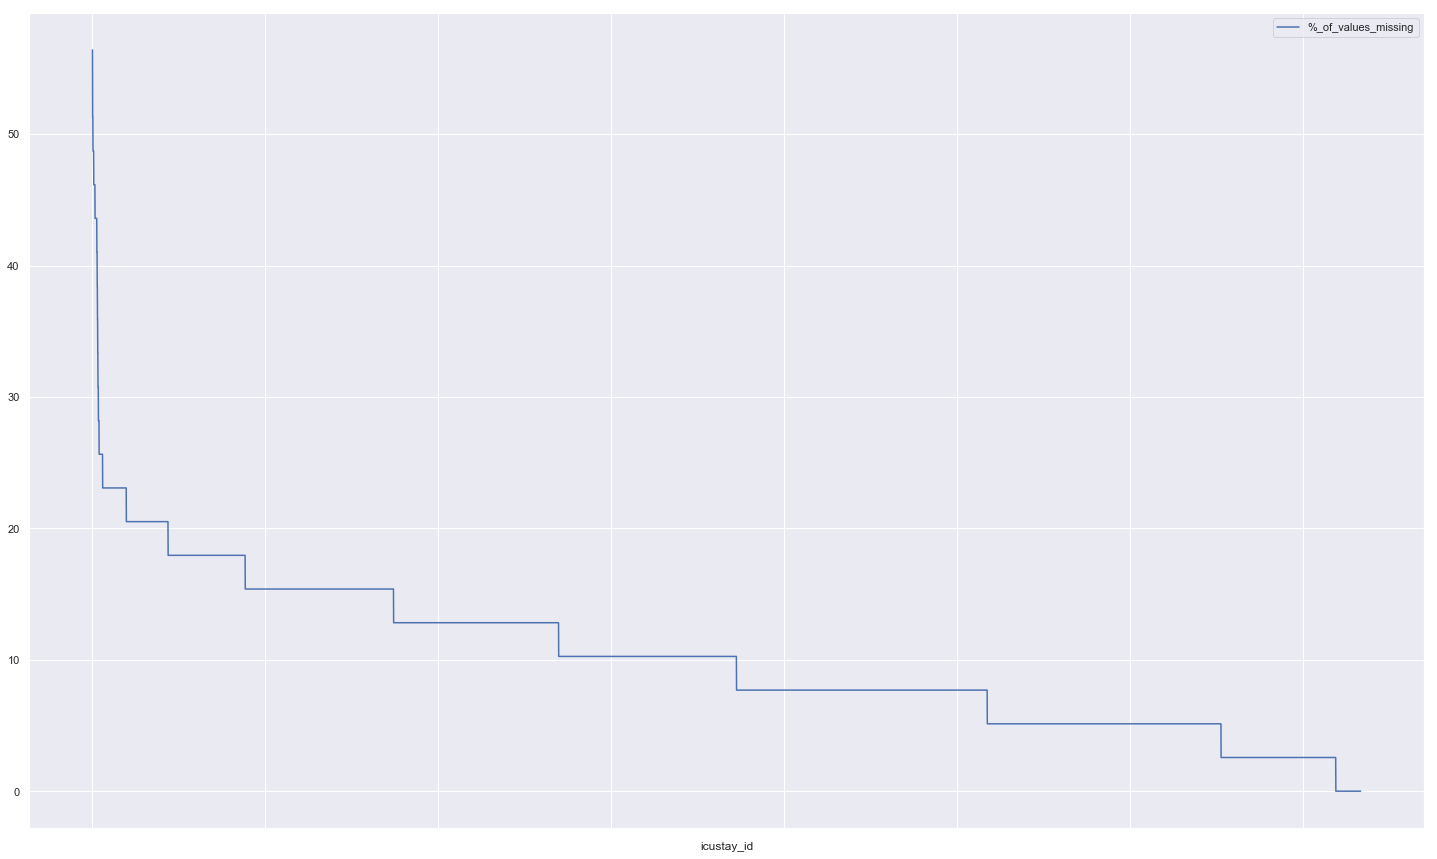

time: 301 ms


In [60]:
big_agg_pt_missing.sort_values('%_of_values_missing',ascending=False).plot()

In [61]:
len(big_agg_pt_missing)

14668

time: 1.74 ms


In [62]:
big_agg_pt_missing.describe()

,%_of_values_missing
count,14668.000000
mean,10.091041
std,5.803368
min,0.000000
25%,5.128205
50%,10.256410
75%,12.820513
max,56.410256


time: 13.2 ms


In [63]:
# def sum_(x):
#     try:
#         return np.sum(x)
#     except:
#         return np.nan

# def max_(x):
#     try:
#         return np.max(x)
#     except:
#         return np.nan

time: 1.28 ms


## data typews

In [64]:
# list1=[]
# list2=[]
# for element in df_list:
#     if 'value' in (list(dfs[element])):
#         list1.append(element)
#     if 'valuenum' in (list(dfs[element])):
#         list2.append(element)




time: 1.07 ms


In [65]:
# for element in list2:
#     print(dfs[element].groupby('label')['valuenum'].describe())

time: 434 µs


In [66]:
# for element in list1:
#     print(dfs[element].groupby('label')['value'].describe())

time: 468 µs


In [67]:
# dfs['bg_ART'].groupby('label')['valuenum'].apply(lambda x: type(x))

time: 418 µs
